# UMAP + KMeans

In [2]:
import pandas as pd
import numpy as np

import umap.umap_ as umap

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

random_seed = 2022
import warnings
warnings.filterwarnings("ignore")

In [3]:
def optimalK(data_type,data, algorithm1, algorithm2, title, random_state=2022, maxClusters=10):
    """
    Calculates optimal K using silhouette score
    Params:
        data_type: df, dissim
        data: ndarry of shape (n_samples, n_features)
        algorithm1: kmeans, kmedoids, or hierarchical
        algorithm2: kmeans, kmedoids, or hierarchical
        title: the title for the resulting figure
        maxClusters: Maximum number of clusters to test for
    Returns: (silh, optimalK)
    """
    silh = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'algorithm':[], 'clusterCount':[], 'silhouette':[]})
    for algorithm in [algorithm1, algorithm2]:
        for index, k in enumerate(range(2, maxClusters)):

            if algorithm == 'kmeans':
                model = KMeans(k, random_state=random_state)
                model.fit(data)
            if algorithm == 'hierarchical':
                model = AgglomerativeClustering(n_clusters=k,linkage = 'ward')
                model.fit(data)

            cluster_labels = model.fit_predict(data)
            silhouette_avg = silhouette_score(data, cluster_labels)
            
            resultsdf = resultsdf.append({'algorithm':algorithm, 'clusterCount':k, 
                                          'silhouette':silhouette_avg}, ignore_index=True)
    
    algorithm1_df = resultsdf[resultsdf['algorithm']==algorithm1]
    algorithm2_df = resultsdf[resultsdf['algorithm']==algorithm2]
    
    # Plot the silhouette scores for each algorithm
    plt.figure(figsize=(7,4))
    plt.xlim(1,maxClusters)
    sns.lineplot(data=resultsdf, x="clusterCount", y="silhouette", hue="algorithm")
    # Indicate the best k for each algorithm
    plt.scatter(algorithm1_df.loc[algorithm1_df['silhouette'].idxmax(),'clusterCount'], 
                algorithm1_df['silhouette'].max())
    plt.scatter(algorithm2_df.loc[algorithm2_df['silhouette'].idxmax(),'clusterCount'], 
                algorithm2_df['silhouette'].max())
    plt.xlabel('Cluster Count')
    plt.ylabel('Silhouette Value')
    plt.title(title)
    return (plt)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

def create_cluster_models(data_type, data, methods, ks, keep_orig=False):
    if data_type == 'df':
        if keep_orig == True:
            clust_results = data.loc[:]
        else:
            clust_results = pd.DataFrame(index=data.index)

        for k in ks:
            for m in methods:
                if m == "KMeans":
                    # KMeans clustering
                    fit_cluster = KMeans(n_clusters=k, random_state=random_seed).fit(data)
                    clust_results['cl_k'+str(k)] = fit_cluster.labels_

                elif m == "Hierarchical":
                    # Hierarchical clustering
                    fit_cluster = AgglomerativeClustering(n_clusters=k,linkage = 'ward').fit(data)
                    clust_results['cl_h'+str(k)] = fit_cluster.labels_

    return clust_results

In [4]:
def optimalK_grouped(data_type,data, algorithm1, algorithm2, title, random_state=2022, maxClusters=10):
    silh = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'algorithm':[], 'clusterCount':[], 'silhouette':[]})
    for algorithm in [algorithm1, algorithm2]:
        for index, k in enumerate(range(2, maxClusters)):
            
            if algorithm == 'kmeans':
                model = KMeans(k, random_state=random_state)
                model.fit(data)
            if algorithm == 'hierarchical':
                model = AgglomerativeClustering(n_clusters=k,linkage = 'ward')
                model.fit(data)

            cluster_labels = model.fit_predict(data)
            silhouette_avg = silhouette_score(data, cluster_labels)                               
            
            resultsdf = resultsdf.append({'algorithm':algorithm, 'clusterCount':k, 
                                          'silhouette':silhouette_avg}, ignore_index=True)
    
    return (resultsdf)


def neigh_dist(dissim):
    """UMAP"""
    neighbors = [3,4,5,6]
    dists = [0.001, 0.01, 0.1]

    umaps_results = pd.DataFrame(columns=['neighbor','distance','Dim1','Dim2'])
    for n in neighbors:
        for d in dists:
            temp_umap = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2,
                                  random_state=random_seed,metric='precomputed').fit_transform(dissim)
            temp_umap = pd.DataFrame(temp_umap, columns=['Dim1','Dim2'])
            temp_umap['neighbor'] = n
            temp_umap['distance'] = d
            umaps_results = umaps_results.append(temp_umap, sort=True,ignore_index=True)
            
    # Create dataframe
    optimal_k_umap = pd.DataFrame()

    for dist in [0.001, 0.01, 0.1]:
        for ngbr in [3,4,5,6]:
            df_subset = umaps_results[(umaps_results['distance']==dist) & (umaps_results['neighbor']==ngbr)].iloc[:,:2]
            temp_df = optimalK_grouped(data_type='df',data=df_subset, algorithm1='kmeans', algorithm2='hierarchical', 
                                       random_state=random_seed, title="test")
            temp_df['distance'] = dist
            temp_df['neighbor'] = ngbr

            optimal_k_umap = optimal_k_umap.append(temp_df, ignore_index=True)


    optimal_k_umap = optimal_k_umap.reset_index(drop=True)
    optimal_k_umap_hierarchical = optimal_k_umap[optimal_k_umap['algorithm']=='hierarchical']
    optimal_k_umap_kmeans = optimal_k_umap[optimal_k_umap['algorithm']=='kmeans']
    
    # Plot
    f,axes = plt.subplots(2,1,figsize=(5,10))
    
    #Hierarchical clustering
    sns.lineplot(data=optimal_k_umap_hierarchical, x="clusterCount", y="silhouette", hue="distance",
                style="neighbor", palette='colorblind',ax=axes[0])
    axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    axes[0].set_title("Optimal Distance and Neighbor for " + " Hierarchical Clustering", fontsize=8)
    axes[0].scatter(optimal_k_umap_hierarchical.loc[optimal_k_umap_hierarchical['silhouette'].idxmax(),'clusterCount'],
                   optimal_k_umap_hierarchical['silhouette'].max(),c='red')
    h_dist = optimal_k_umap_hierarchical.loc[optimal_k_umap_hierarchical['silhouette'].idxmax(),'distance']
    h_neigh = optimal_k_umap_hierarchical.loc[optimal_k_umap_hierarchical['silhouette'].idxmax(),'neighbor']
    
    #KMeans clustering
    sns.lineplot(data=optimal_k_umap_kmeans, x="clusterCount", y="silhouette", hue="neighbor",
             style="distance", palette='colorblind')
    plt.title("Optimal Distance and Neighbor for " + " KMeans Clustering", fontsize=8)
    plt.scatter(optimal_k_umap_kmeans.loc[optimal_k_umap_kmeans['silhouette'].idxmax(),'clusterCount'],
                    optimal_k_umap_kmeans['silhouette'].max(),c='red')
    k_dist = optimal_k_umap_kmeans.loc[optimal_k_umap_kmeans['silhouette'].idxmax(),'distance']
    k_neigh = optimal_k_umap_kmeans.loc[optimal_k_umap_kmeans['silhouette'].idxmax(),'neighbor']
    
    #result_dict = {'hierarchical':optimal_k_umap_hierarchical,'kmeans':optimal_k_umap_kmeans,
    #               'h_parameter':[h_dist,h_neigh],'k_parameter':[k_dist,k_neigh]}
    result_dict = {'h_parameter':[h_dist,h_neigh],'k_parameter':[k_dist,k_neigh]}
    return(result_dict)

{'h_parameter': [0.1, 3], 'k_parameter': [0.1, 3]}

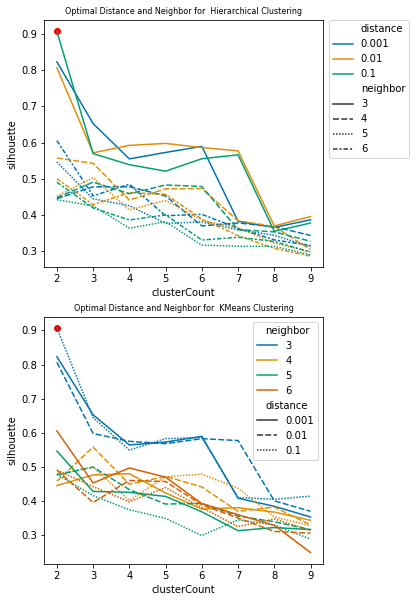

In [5]:
raw = pd.read_csv('output_data/models_rdm/full_feature/raw33d_dissim_dist.csv',
                  index_col=0,encoding = "UTF-8")
dissim = raw
neigh_dist(raw)

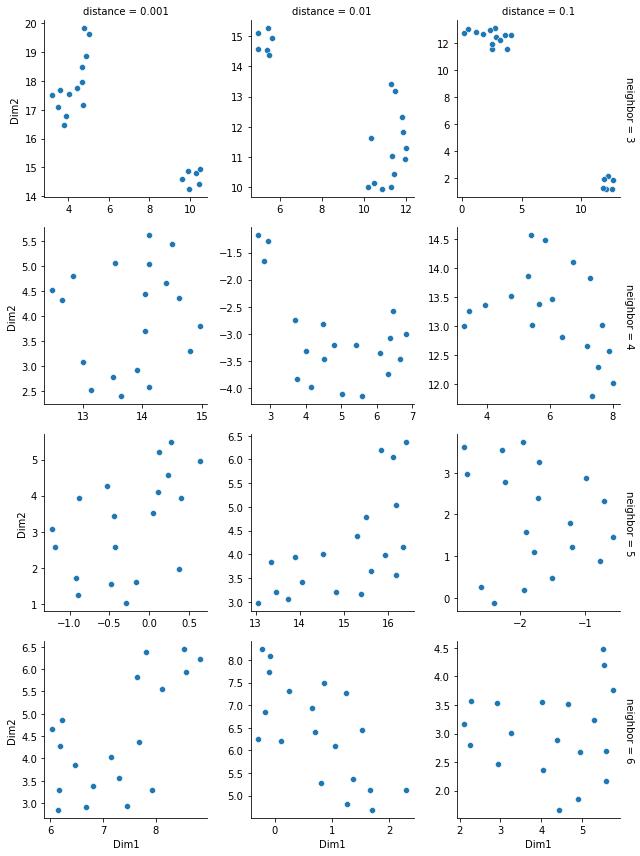

In [6]:
neighbors = [3,4,5,6]
dists = [0.001, 0.01, 0.1]

umaps_results = pd.DataFrame(columns=['neighbor','distance','Dim1','Dim2'])
for n in neighbors:
    for d in dists:
        temp_umap = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2,
                              metric = 'precomputed',
                              random_state=2022).fit_transform(dissim)
        temp_umap = pd.DataFrame(temp_umap, columns=['Dim1','Dim2'])
        temp_umap['neighbor'] = n
        temp_umap['distance'] = d
        umaps_results = umaps_results.append(temp_umap, sort=True, 
                                             ignore_index=True)
        
g = sns.FacetGrid(umaps_results, row='neighbor', col='distance',
                  margin_titles=True, sharex=False, sharey=False)
g.map(sns.scatterplot, 'Dim1', 'Dim2')

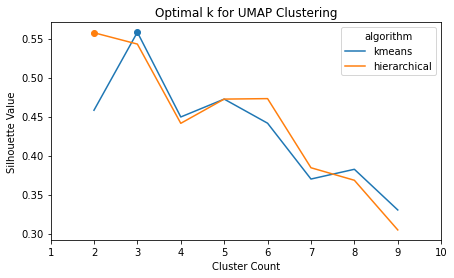

In [7]:
umap_final = umap.UMAP(n_neighbors=4, min_dist=0.01, n_components=2,
                    random_state=random_seed,metric='precomputed').fit_transform(dissim)
umap_final = pd.DataFrame(umap_final, columns=['Dim1','Dim2'],index = dissim.index)

optimalK(data_type='df',data=umap_final, algorithm1='kmeans', algorithm2='hierarchical', 
         random_state=2022, title="Optimal k for UMAP Clustering")

umap_results = create_cluster_models(data_type = "df",data = umap_final,
                                       methods=['KMeans', 'Hierarchical'],ks=[2,3,4,5,6],keep_orig=True)
umap_results.to_csv('output_data/clustering_19regions/raw33d_4_0.01.csv')

# Plot results

## version1

In [2]:
library(tidyverse)
library(reshape)

library(ggplot2)
library(ggrepel)
library(ggdendro) #get the details
library(dendextend) #change the plot
library(ape)

In [3]:
plot_results = function(umap_results,method_num){
    options(repr.plot.width=5,repr.plot.height=5)
    ggplot(umap_results,aes(x=Dim1,y=Dim2,color=factor(.data[[method_num]]))) + 
    geom_point(size = 3) + 
    geom_text_repel(aes(label = rownames(umap_results)),size = 6,
                   max.overlaps = getOption("ggrepel.max.overlaps", default = 20))+
    #ggtitle(strsplit(output_file,'.csv')[[1]][1])+
    theme_classic()+
    theme(plot.title = element_text(size = 30, face = "bold"),
         legend.position = 'none')
}

[1] "Hierarchical:"


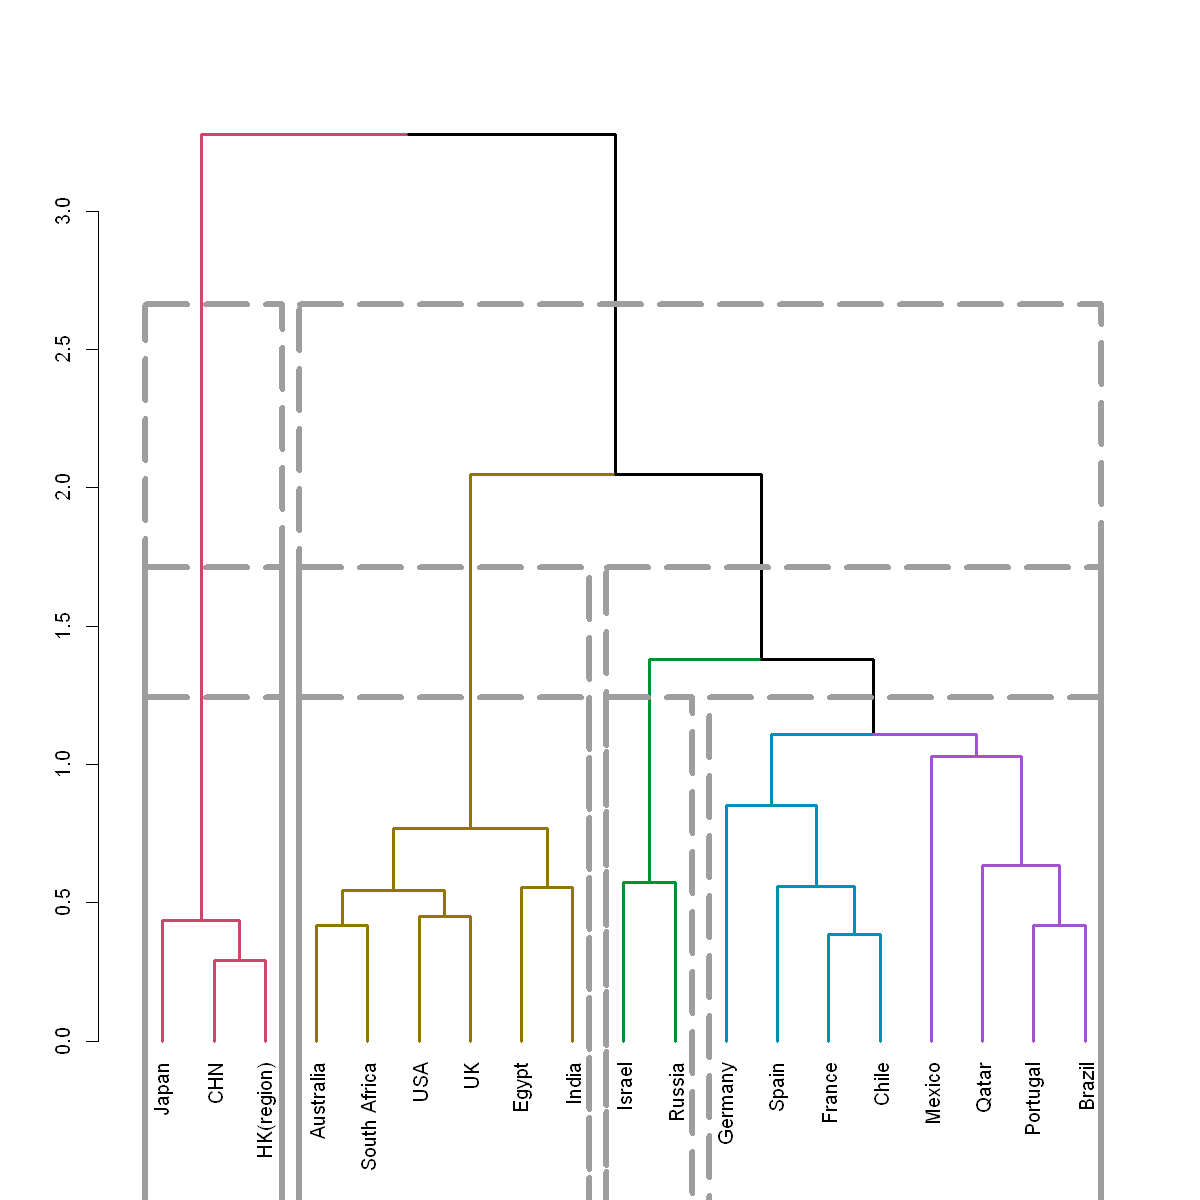

In [4]:
raw_results=read.csv('output_data/clustering_19regions/raw33d_4_0.01.csv',row.names=1)
# KMeans
# print('KMeans:')
# plot_results(raw_results,'cl_k2')
# plot_results(raw_results,'cl_k3')
# plot_results(raw_results,'cl_k4')
# plot_results(raw_results,'cl_k5')

print('Hierarchical:')
# Hierarchical
options(repr.plot.width=10,repr.plot.height=10)
dend = dist(raw_results[c('Dim1','Dim2')],method='euclidean') %>% 
    as.dist() %>%
    hclust(method = "average") %>%
    as.dendrogram() %>%    
    set("labels_cex", 1) %>% 
    set("branches_lwd", 3) %>%
    set("branches_k_color",k=5)
plot(dend)
dend %>% rect.dendrogram(k=2, border = 8, lty = 5, lwd = 5)
dend %>% rect.dendrogram(k=3, border = 8, lty = 5, lwd = 5)
dend %>% rect.dendrogram(k=4, border = 8, lty = 5, lwd = 5)
#dend %>% rect.dendrogram(k=5, border = 8, lty = 5, lwd = 5)
#dend %>% rect.dendrogram(k=6, border = 8, lty = 5, lwd = 5)

png 
  2

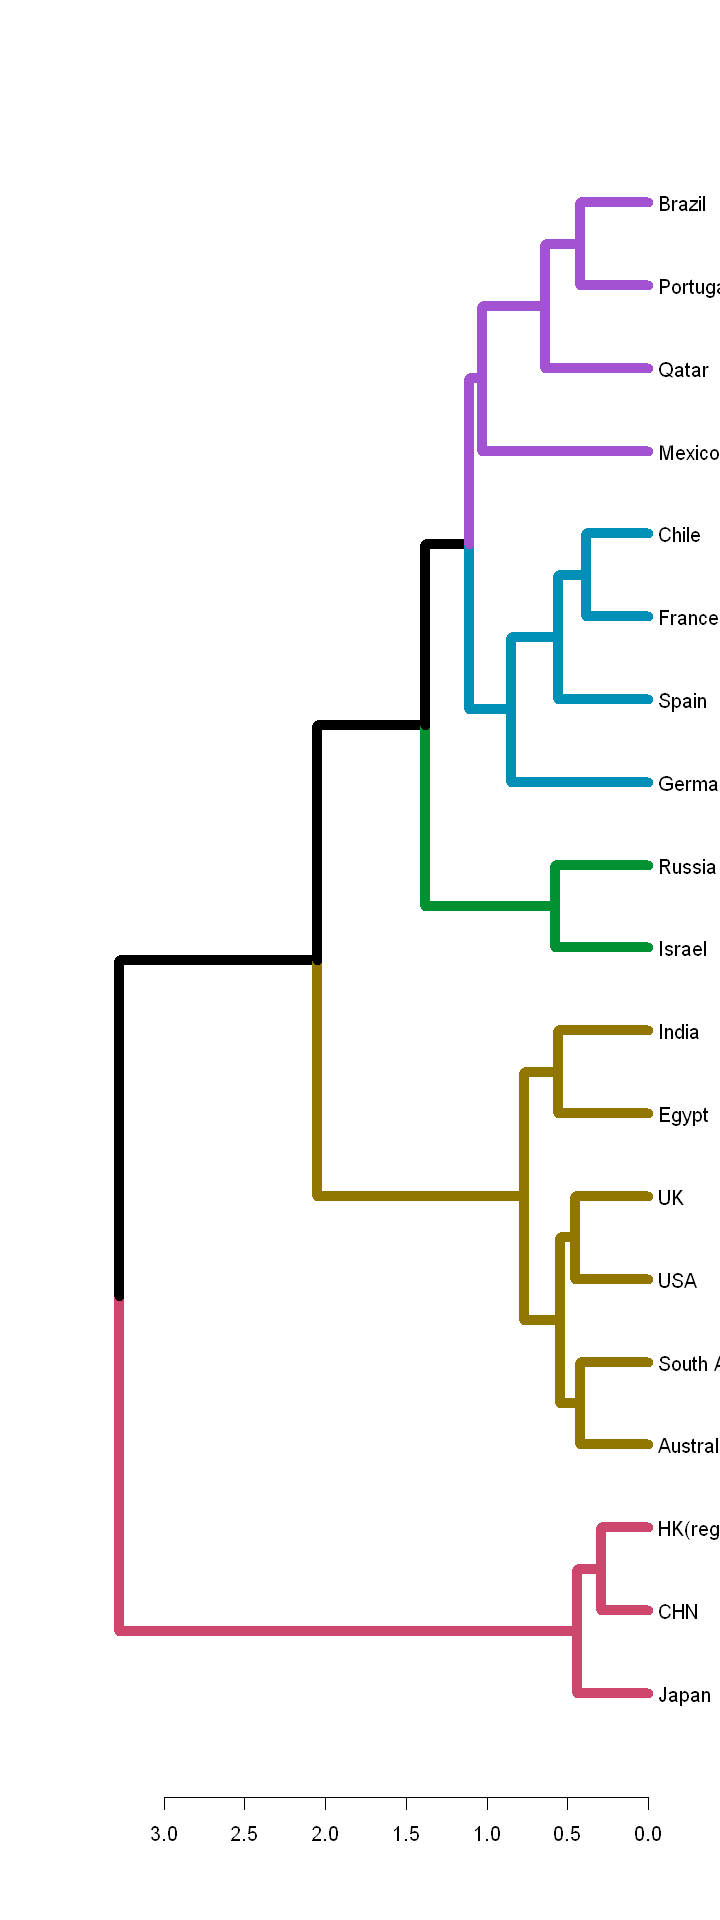

In [5]:
options(repr.plot.width=6,repr.plot.height=16)
dend = dist(raw_results[c('Dim1','Dim2')],method='euclidean') %>% 
    as.dist() %>%
    hclust(method = "average") %>%
    as.dendrogram() %>%    
    set("labels_cex", 1) %>% 
    set("branches_lwd", 8) %>%
    set("branches_k_color",k=5)
plot(dend,horiz = TRUE)

######################################################
png("../output_graph/Clustering19regions.png", bg="transparent",
    family = 'sans',units='in',width=6,height=16,res=300)
dend = dist(raw_results[c('Dim1','Dim2')],method='euclidean') %>% 
    as.dist() %>%
    hclust(method = "average") %>%
    as.dendrogram() %>%    
    set("labels_cex", 1) %>% 
    set("branches_lwd", 8) %>%
    set("branches_k_color",k=5)
plot(dend,horiz = TRUE,leaflab = "none")
dev.off()

## version2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.cluster import hierarchy as hch
from scipy.cluster.hierarchy import linkage, ward, fcluster

from IPython.display import HTML, Javascript, display

def configure_d3():
    display(Javascript("""
    require.config({
      paths: {
        d3: "https://d3js.org/d3.v4.min"
      }
    })"""))


configure_d3()

<IPython.core.display.Javascript object>

In [2]:
raw_results = pd.read_csv('output_data/clustering_19regions/raw33d_4_0.01.csv',index_col=0)
raw_results = raw_results.iloc[:,0:2]
df = raw_results
df

,Dim1,Dim2
USA,6.304913,-3.741505
UK,6.659119,-3.459787
Australia,6.079749,-3.361766
South Africa,6.384095,-3.074868
Germany,5.408632,-3.200981
Japan,2.831515,-1.647420
Israel,5.006890,-4.109444
CHN,2.924335,-1.283457
HK(region),2.652380,-1.179938
France,4.794179,-3.209142


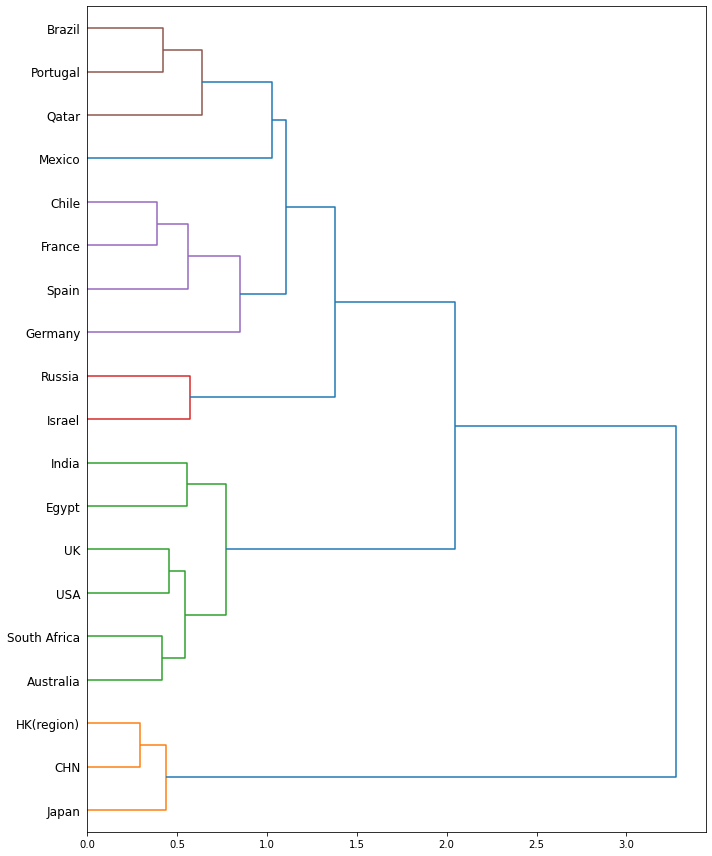

In [3]:
Z = hch.linkage(df, 'average')
fig = plt.figure(figsize=(10, 12))

dn = hch.dendrogram(Z, labels = df.index, leaf_rotation = 0, leaf_font_size = 12, 
                    orientation = 'right', 
                    color_threshold = 0.95)

fig.tight_layout()
#plt.savefig('hca.png', format = 'png', transparent = False, bbox_inches = "tight")
plt.show()

rootnode, node_list = hch.to_tree(Z, rd = True) #ClusterNodes

N = len(node_list) - 1
geneology = dict()
node_hierarchy = list()
study = list()

In [4]:
for node in node_list[::-1]: #Cycle through the nodes, in the reverse order to which they are stored  
    
    id_ = N - node.id #Create an id variable which subtracts the node's id from N
    
    if id_ == 0: #Where this variable is 0, we have the root node
        geneology[id_] = str(id_) #Make the new id variable a key:pair in geneology
    
    if id_ not in geneology: #If the current id variable is not a key in geneology (i.e., we have not added it)
        
        for node2 in node_list: #Cycle through the node list again, but in the original order      
            
            if (node2.count != 1): #And if the node in this loop does not have a single sample
                
                #And if the new node is not a left or right child tree node of the original node
                if (node.id == node2.left.id) or (node.id == node2.right.id): 
                    id2 = N - node2.id #Create a new id of the new node which is its current id subtracted from N
                    
                    if node.dist == 0: #If the original node's distance is 0
                        #Take the row of the dataframe that was used for the clutsering which
                        #has an index corresponding to the original node's id
                        row = df.iloc[node.id]
                        rel = row.name #And get the name of that row (it's index label: relationship name)
                        s = 1
                        #if rel in s2:
                        #    s = 2
                        #else:
                        #    s = 1
                        #The id of the original node is added as a key to geneology
                        #But the value is now the new value of the new node already stored in geneology 
                        #concatenated with the relationship name
                        geneology[id_] = geneology[id2] + "." + rel 
                    
                    else: #If the original node's distance is not 0, the concatenated value is the string of the id
                        geneology[id_] = geneology[id2] + "." + str(id_)
                    break 
    
    hierarchy = geneology[id_] #Take the value in geneology[id_]
    if node.dist == 0:
        row = df.iloc[node.id]
        rel = row.name
        s = 1
        #if rel in s2:
        #    s = 2
        #else:
        #    s = 1
        node_hierarchy.append([hierarchy, s])
    else:
        node_hierarchy.append([hierarchy, None])

In [5]:
d3_df = pd.DataFrame(node_hierarchy)
d3_df.columns = ['id', 'study']
d3_df.index = d3_df['id']
d3_df.loc[[i for i in  d3_df['id'] if i.startswith('0.1.6.10.')],'study'] = 2

d3_df.index = range(len(d3_df))
d3_df.to_csv('output_data/clustering_19regions/d3_hca.csv', index = False)
d3_df

,id,study
0,0,NaN
1,0.1,NaN
2,0.1.2,NaN
3,0.1.2.3,NaN
4,0.1.2.3.4,NaN
5,0.1.2.3.5,NaN
6,0.1.6,NaN
7,0.1.2.3.4.7,NaN
8,0.1.2.8,NaN
9,0.1.2.3.5.9,NaN


Delete the code following to display text<br>  
.node text {<br>
  font-size: 0px;<br>
  line-height: 0.5;<br>
  font-family: Arial;<br>
}

In [6]:
%%html

<style>
    body {
      font-family: Arial;
    }
    .node text {
      font-size: 0px;
      line-height: 0.5;
      font-family: Arial;
    }
    .link {
      fill: none;
      stroke: #555;
      stroke-opacity: 0.8;
      stroke-width: 4.0px;
    }

    .link.cluster-one {
      stroke: #7C000C;
    }

    .link.cluster-two {
      stroke: #CC4950;
    }

    .link.cluster-three {
      stroke: #808000;
    }

    .link.cluster-four {
      stroke: #99FF33;
    }

    .link.cluster-five {
      stroke: #14405A;
    }

    .link.cluster-six{
      stroke: #713585;
    }

</style>

<body>

    <svg id="img_regions_clustering" width="1200" height="1200"></svg>

    <script>
      var width = 600,
          height = 600;

    require(['d3'], function (d3) {

      var svg = d3.select("#img_regions_clustering"),
          g = svg.append("g").attr("transform", "translate(" + ((width / 2)+0) +
                              "," + (height / 2 + 0) + ")"),
          legend = svg.append("g");


      var stratify = d3.stratify()
                       .parentId(function(d)
                          { return d.id.substring(0, d.id.lastIndexOf(".")); });

      var cluster = d3.cluster()
                      .size([360, width / 2 - 120]);

      function project(x, y) {
        var angle = (x - 90) / 180 * Math.PI, radius = y;
        return [radius * Math.cos(angle), radius * Math.sin(angle)];
      }


      d3.csv("output_data/clustering_19regions/d3_hca.csv", function(error, data) {
        if (error) throw error;

        var root = stratify(data).sort(function(a, b) {
                        return a.height - b.height || a.id.localeCompare(b.id);
                      });

        cluster(root);

        var link = g.selectAll(".link")
                    .data(root.descendants().slice(1))
                    .enter().append("path")
                    .attr("d", function(d) {
                      return "M" + project(d.x, d.y)
                          + "C" + project(d.x, (d.y + d.parent.y) / 2)
                          + " " + project(d.parent.x, (d.y + d.parent.y) / 2)
                          + " " + project(d.parent.x, d.parent.y);
                    });

      link.attr("class", function(d) {
              var id = d.data.id;
              if (id.slice(2,4)== "13") {
                  return "link cluster-one";
              } else if (id.slice(2,8) == "1.6.10") {
                  return "link cluster-two";
              } else if (id.slice(2,5) == "1.6") {
              return "link cluster-three";
              
              } else if (id.slice(2,9) == "1.2.3.4") {
              return "link cluster-five";
              } else if (id.slice(2,9) == "1.2.3.5") {
              return "link cluster-six";
              } else if (id.slice(2,7) == "1.2.3") {    
              return "link";
              } else if (id.slice(2,5) == "1.2") {
              return "link cluster-four";
              } else {
                return "link";
              }


            });

        var node = g.selectAll(".node")
                    .data(root.descendants())
                    .enter().append("g")
                    .attr("class", function(d) {
                      return "node" + (d.children ? " node--internal" : " node--leaf");
                    })
                    .attr("transform", function(d) {
                      return "translate(" + project(d.x, d.y) + ")";
                    });
          

        var leaf = g.selectAll(".node--leaf")
                    .append("circle")
                    .attr("r", 0)
                    .classed("cluster-one", function(d){
                      var id = d.data.id;
                      return (id.slice(2,5)== "13.");
                    })
                    .classed("cluster-two", function(d){
                      var id = d.data.id;
                      return (id.slice(2,8) == "1.6.10");
                    });
                
         

        node.append("text")
            .attr("dy", "0.31em")
            .attr("x", function(d) {
              return d.x < 180 === !d.children ? 6 : -6;
            })
            .style("text-anchor", function(d) {
              return d.x < 180 === !d.children ? "start" : "end";
            })
            .attr("transform", function(d) {
              return "rotate(" + (d.x < 180 ? d.x - 90 : d.x + 90) + ")";
            })
            .text(function(d) {
              if (typeof d.children == "undefined") {
                  return d.id.substring(d.id.lastIndexOf(".") + 1);
              }
            })
            .attr("class", function(d){
              var id = d.data.id;
              if (id.slice(2,5)== "13.") {
                  return "East-Asian";
              } else if (id.slice(2,8) == "1.6.10") {
                  return "Hinduism-Islam";
              } else if (id.slice(2,10) == "1.6.11.1") {
                   return "Protestantism";
              } else if (id.slice(2,7) == "1.2.8") {
                return "Judaism-Orthodoxy";
              } else if (id.slice(2,9) == "1.2.3.4") {
                return "Catholicism-Traditional";
              } else if (id.slice(2,9) == "1.2.3.5") {
                return "Catholicism-Modern";
              } else {
                return "black";
              }


            });
      });
    });            
    </script>

</body>